In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import time
import os
from datetime import datetime

# Sklearn - Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Sklearn - Modèles
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

# Sklearn - Métriques
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

# Sauvegarde
import joblib

# ════════════════════════════════════════════════════════════════════════
# Configuration
# ════════════════════════════════════════════════════════════════════════

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd. set_option('display.precision', 4)
pd.set_option('display.width', 120)

# Seed pour reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ════════════════════════════════════════════════════════════════════════
# Affichage
# ════════════════════════════════════════════════════════════════════════

print("="*80)
print("🤖 MODÉLISATION METABRIC - PRÉDICTION D'AGRESSIVITÉ")
print("="*80)
print(f"\n📅 Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🐍 Python : {pd.__version__}")
print(f"📊 Pandas : {pd.__version__}")
print(f"🔢 NumPy : {np.__version__}")
print(f"📈 Matplotlib : {plt. matplotlib.__version__}")
print(f"📉 Seaborn : {sns.__version__}")

print("\n✅ Configuration terminée !")
print("="*80)

🤖 MODÉLISATION METABRIC - PRÉDICTION D'AGRESSIVITÉ

📅 Date : 2025-12-05 11:44:15
🐍 Python : 2.2.0
📊 Pandas : 2.2.0
🔢 NumPy : 1.26.4
📈 Matplotlib : 3.8.3
📉 Seaborn : 0.13.2

✅ Configuration terminée !


In [17]:
print("\n" + "="*80)
print("📂 CHARGEMENT DES DONNÉES")
print("="*80)

# ════════════════════════════════════════════════════════════════════════
# Charger le fichier CSV
# ════════════════════════════════════════════════════════════════════════

data_path = 'data/row/metabric_clean.csv'

# Vérifier que le fichier existe
if not os.path.exists(data_path):
    print(f"❌ ERREUR : Fichier introuvable !")
    print(f"   Chemin : {data_path}")
    print(f"   Vérifiez que vous avez bien exporté les données")
else:
    print(f"✅ Fichier trouvé : {data_path}")
    
    # Charger les données
    print(f"\n📥 Chargement en cours...")
    data = pd.read_csv(data_path, index_col=0)
    
    print(f"✅ Données chargées avec succès !")
    print(f"\n📊 Informations générales :")
    print(f"   Shape : {data.shape}")
    print(f"   Patients : {data. shape[0]}")
    print(f"   Colonnes : {data.shape[1]}")
    print(f"   Taille en mémoire : {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # ════════════════════════════════════════════════════════════════════
    # Séparer Features (X) et Cibles (y)
    # ════════════════════════════════════════════════════════════════════
    
    print(f"\n📦 Séparation Features / Cibles...")
    
    # Colonnes cibles
    target_cols = ['aggressiveness_score', 'growth_rate', 'evolution_6m']
    
    # Vérifier que les cibles existent
    missing_targets = [col for col in target_cols if col not in data.columns]
    
    if missing_targets:
        print(f"\n❌ ERREUR : Colonnes cibles manquantes : {missing_targets}")
    else:
        # Séparer X et y
        X_metabric = data.drop(columns=target_cols)
        y_metabric = data[target_cols]
        
        print(f"\n✅ Séparation réussie !")
        print(f"\n   📊 X (Features) :")
        print(f"      Shape : {X_metabric. shape}")
        print(f"      Colonnes : {X_metabric.shape[1]}")
        print(f"      Types : {X_metabric.dtypes. value_counts(). to_dict()}")
        
        print(f"\n   🎯 y (Cibles) :")
        print(f"      Shape : {y_metabric.shape}")
        print(f"      Colonnes : {list(y_metabric.columns)}")
        
        # Vérifier types numériques
        non_numeric_X = X_metabric.select_dtypes(exclude=[np.number]).columns. tolist()
        
        if non_numeric_X:
            print(f"\n   ⚠️ ATTENTION : Colonnes non-numériques dans X : {non_numeric_X}")
            print(f"      → Conversion automatique...")
            for col in non_numeric_X:
                X_metabric[col] = pd.to_numeric(X_metabric[col], errors='coerce')
            X_metabric = X_metabric.fillna(0)
            print(f"      ✅ Conversion terminée")
        else:
            print(f"\n   ✅ Toutes les features sont numériques")

print("\n" + "="*80)


📂 CHARGEMENT DES DONNÉES
✅ Fichier trouvé : data/row/metabric_clean.csv

📥 Chargement en cours...
✅ Données chargées avec succès !

📊 Informations générales :
   Shape : (1904, 27)
   Patients : 1904
   Colonnes : 27
   Taille en mémoire : 0.41 MB

📦 Séparation Features / Cibles...

✅ Séparation réussie !

   📊 X (Features) :
      Shape : (1904, 24)
      Colonnes : 24
      Types : {dtype('int64'): 19, dtype('float64'): 5}

   🎯 y (Cibles) :
      Shape : (1904, 3)
      Colonnes : ['aggressiveness_score', 'growth_rate', 'evolution_6m']

   ✅ Toutes les features sont numériques



In [18]:
print("\n" + "="*80)
print("🔍 EXPLORATION DES DONNÉES")
print("="*80)

# ════════════════════════════════════════════════════════════════════════
# Aperçu des données
# ════════════════════════════════════════════════════════════════════════

print(f"\n📊 Aperçu des 5 premières lignes :\n")
print(data.head())

# ════════════════════════════════════════════════════════════════════════
# Statistiques Features
# ════════════════════════════════════════════════════════════════════════

print(f"\n📈 Statistiques des Features :\n")
print(X_metabric.describe(). T[['mean', 'std', 'min', 'max']])

# ════════════════════════════════════════════════════════════════════════
# Statistiques Cibles
# ════════════════════════════════════════════════════════════════════════

print(f"\n🎯 Statistiques des Cibles :\n")
print(y_metabric. describe().T)

# Distribution evolution_6m
print(f"\n📊 Distribution de evolution_6m :")
evol_dist = y_metabric['evolution_6m'].value_counts(). sort_index()
for idx, count in evol_dist.items():
    label = {0: 'Stable', 1: 'Modéré', 2: 'Rapide'}.get(idx, idx)
    pct = count / len(y_metabric) * 100
    print(f"   {label} ({idx}) : {count:4d} ({pct:5.1f}%)")

# ════════════════════════════════════════════════════════════════════════
# Vérifications de qualité
# ════════════════════════════════════════════════════════════════════════

print(f"\n🔍 Vérifications de qualité :")

# Valeurs manquantes
nan_X = X_metabric.isna().sum().sum()
nan_y = y_metabric.isna().sum().sum()
print(f"   • Valeurs manquantes X : {nan_X}")
print(f"   • Valeurs manquantes y : {nan_y}")

# Valeurs infinies
inf_X = np.isinf(X_metabric).sum().sum()
inf_y = np.isinf(y_metabric).sum(). sum()
print(f"   • Valeurs infinies X : {inf_X}")
print(f"   • Valeurs infinies y : {inf_y}")

# Doublons
duplicates = data. duplicated().sum()
print(f"   • Lignes dupliquées : {duplicates}")

if nan_X == 0 and nan_y == 0 and inf_X == 0 and inf_y == 0 and duplicates == 0:
    print(f"\n✅ Données de qualité : Prêtes pour la modélisation !")
else:
    print(f"\n⚠️ Quelques problèmes détectés, mais gérables")

print("\n" + "="*80)


🔍 EXPLORATION DES DONNÉES

📊 Aperçu des 5 premières lignes :

   age_at_diagnosis  tumor_size  lymph_nodes_examined_positive  nottingham_prognostic_index  mutation_count  grade  \
0             75.65        22.0                            5.0                        6.044             5.0      3   
1             43.19        10.0                            0.0                        4.020             2.0      3   
2             48.87        15.0                            1.0                        4.030             2.0      2   
3             47.68        25.0                            3.0                        4.050             1.0      2   
4             76.97        40.0                            5.0                        6.080             2.0      3   

   stage_encoded  cellularity_encoded  er_status_binary  her2_status_binary  pr_status_binary  \
0              2                    2                 1                   0                 0   
1              1                  

In [19]:
print("\n" + "="*80)
print("✂️ SPLIT TRAIN / TEST")
print("="*80)

# ════════════════════════════════════════════════════════════════════════
# Split avec stratification sur evolution_6m
# ════════════════════════════════════════════════════════════════════════

print(f"\n🔄 Split en cours (80% train / 20% test)...")
print(f"   Stratification sur 'evolution_6m' pour équilibrer les classes")

X_train, X_test, y_train, y_test = train_test_split(
    X_metabric,
    y_metabric,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_metabric['evolution_6m']
)

# ════════════════════════════════════════════════════════════════════════
# Afficher résultats
# ════════════════════════════════════════════════════════════════════════

print(f"\n✅ SPLIT TERMINÉ !")

print(f"\n📦 Ensemble TRAIN :")
print(f"   X_train : {X_train.shape} ({X_train.shape[0]/len(X_metabric)*100:.1f}%)")
print(f"   y_train : {y_train.shape}")

print(f"\n📦 Ensemble TEST :")
print(f"   X_test  : {X_test.shape} ({X_test.shape[0]/len(X_metabric)*100:.1f}%)")
print(f"   y_test  : {y_test.shape}")

# ════════════════════════════════════════════════════════════════════════
# Vérifier distribution evolution_6m
# ════════════════════════════════════════════════════════════════════════

print(f"\n📊 Distribution de evolution_6m après split :")

print(f"\n   TRAIN :")
train_dist = y_train['evolution_6m'].value_counts(normalize=True). sort_index() * 100
for idx, val in train_dist.items():
    label = {0: 'Stable', 1: 'Modéré', 2: 'Rapide'}.get(idx, idx)
    print(f"      {label} ({idx}) : {val:5.1f}%")

print(f"\n   TEST :")
test_dist = y_test['evolution_6m'].value_counts(normalize=True).sort_index() * 100
for idx, val in test_dist.items():
    label = {0: 'Stable', 1: 'Modéré', 2: 'Rapide'}.get(idx, idx)
    print(f"      {label} ({idx}) : {val:5.1f}%")

print(f"\n   ✅ Distributions similaires (stratification réussie)")

print("\n" + "="*80)


✂️ SPLIT TRAIN / TEST

🔄 Split en cours (80% train / 20% test)...
   Stratification sur 'evolution_6m' pour équilibrer les classes

✅ SPLIT TERMINÉ !

📦 Ensemble TRAIN :
   X_train : (1523, 24) (80.0%)
   y_train : (1523, 3)

📦 Ensemble TEST :
   X_test  : (381, 24) (20.0%)
   y_test  : (381, 3)

📊 Distribution de evolution_6m après split :

   TRAIN :
      Stable (0) :  92.4%
      Modéré (1) :   5.6%
      Rapide (2) :   2.0%

   TEST :
      Stable (0) :  92.4%
      Modéré (1) :   5.8%
      Rapide (2) :   1.8%

   ✅ Distributions similaires (stratification réussie)



In [20]:
print("\n" + "="*80)
print("📏 STANDARDISATION DES FEATURES")
print("="*80)

print(f"\n⚠️ IMPORTANT : Standardisation APRÈS le split")
print(f"   → Évite le data leakage (fuite d'information vers le test)")

# ════════════════════════════════════════════════════════════════════════
# Créer et fitter le scaler
# ════════════════════════════════════════════════════════════════════════

scaler_metabric = StandardScaler()

print(f"\n📐 Calcul des paramètres (moyenne, écart-type) sur TRAIN uniquement...")
scaler_metabric.fit(X_train)

# ════════════════════════════════════════════════════════════════════════
# Transformer train et test
# ════════════════════════════════════════════════════════════════════════

print(f"🔄 Transformation des données...")

X_train_scaled = scaler_metabric. transform(X_train)
X_test_scaled = scaler_metabric.transform(X_test)

# Reconvertir en DataFrame
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns=X_train.columns,
    index=X_train. index
)

X_test_scaled = pd.DataFrame(
    X_test_scaled,
    columns=X_test.columns,
    index=X_test. index
)

# ════════════════════════════════════════════════════════════════════════
# Vérifier statistiques
# ════════════════════════════════════════════════════════════════════════

print(f"\n✅ STANDARDISATION TERMINÉE !")

print(f"\n📊 Statistiques X_train_scaled :")
print(f"   Moyenne : {X_train_scaled.mean(). mean():.6f} (attendu ≈ 0)")
print(f"   Écart-type : {X_train_scaled.std().mean():.6f} (attendu ≈ 1)")
print(f"   Min : {X_train_scaled.min(). min():.2f}")
print(f"   Max : {X_train_scaled.max().max():.2f}")

print(f"\n📊 Statistiques X_test_scaled :")
print(f"   Moyenne : {X_test_scaled.mean().mean():.6f} (légères différences OK)")
print(f"   Écart-type : {X_test_scaled.std().mean():.6f}")

# Vérifier NaN/Inf
nan_train = X_train_scaled.isna().sum().sum()
nan_test = X_test_scaled.isna().sum().sum()
inf_train = np.isinf(X_train_scaled).sum().sum()
inf_test = np.isinf(X_test_scaled).sum().sum()

if nan_train == 0 and nan_test == 0 and inf_train == 0 and inf_test == 0:
    print(f"\n   ✅ Aucune valeur NaN ou Inf détectée")
else:
    print(f"\n   ⚠️ ATTENTION : NaN={nan_train+nan_test}, Inf={inf_train+inf_test}")

print("\n" + "="*80)
print("✅ Données prêtes pour l'entraînement !")
print("="*80)


📏 STANDARDISATION DES FEATURES

⚠️ IMPORTANT : Standardisation APRÈS le split
   → Évite le data leakage (fuite d'information vers le test)

📐 Calcul des paramètres (moyenne, écart-type) sur TRAIN uniquement...
🔄 Transformation des données...

✅ STANDARDISATION TERMINÉE !

📊 Statistiques X_train_scaled :
   Moyenne : 0.000000 (attendu ≈ 0)
   Écart-type : 1.000328 (attendu ≈ 1)
   Min : -3.36
   Max : 17.84

📊 Statistiques X_test_scaled :
   Moyenne : -0.001511 (légères différences OK)
   Écart-type : 0.995806

   ✅ Aucune valeur NaN ou Inf détectée

✅ Données prêtes pour l'entraînement !


In [21]:
print("\n" + "="*80)
print("🤖 COMPARAISON DE MODÈLES")
print("="*80)

# ════════════════════════════════════════════════════════════════════════
# Définir les modèles à comparer
# ════════════════════════════════════════════════════════════════════════

print(f"\n📋 Modèles à tester :")
print(f"   1. Random Forest (Bagging)")
print(f"   2. Gradient Boosting (Boosting) ⭐ Recommandé médical")

models_to_compare = {
    'Random Forest': MultiOutputRegressor(
        RandomForestRegressor(
            n_estimators=200,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            max_features='sqrt',
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=0
        )
    ),
    
    'Gradient Boosting': MultiOutputRegressor(
        GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5,
            min_samples_split=20,
            min_samples_leaf=10,
            subsample=0.8,
            random_state=RANDOM_STATE,
            verbose=0
        )
    ),
}

# ════════════════════════════════════════════════════════════════════════
# Entraîner et évaluer chaque modèle
# ════════════════════════════════════════════════════════════════════════

comparison_results = {}

for model_name, model in models_to_compare.items():
    
    print(f"\n{'─'*80}")
    print(f"🔄 MODÈLE : {model_name}")
    print('─'*80)
    
    # Mesurer temps
    start_time = time.time()
    
    # Entraînement
    print(f"   ⏳ Entraînement en cours...")
    model.fit(X_train_scaled, y_train)
    
    train_time = time.time() - start_time
    print(f"   ✅ Entraînement terminé en {train_time:.1f} secondes ({train_time/60:.1f} min)")
    
    # Prédictions
    print(f"   🔮 Prédictions...")
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Stocker résultats
    results = {
        'model': model,
        'train_time': train_time,
        'predictions': {'train': y_train_pred, 'test': y_test_pred}
    }
    
    # ════════════════════════════════════════════════════════════════════
    # Calculer métriques pour chaque cible
    # ════════════════════════════════════════════════════════════════════
    
    # CIBLE 1 : Aggressiveness Score
    r2_train_aggr = r2_score(y_train. iloc[:, 0], y_train_pred[:, 0])
    r2_test_aggr = r2_score(y_test.iloc[:, 0], y_test_pred[:, 0])
    mae_test_aggr = mean_absolute_error(y_test.iloc[:, 0], y_test_pred[:, 0])
    rmse_test_aggr = np.sqrt(mean_squared_error(y_test.iloc[:, 0], y_test_pred[:, 0]))
    
    # CIBLE 2 : Growth Rate
    r2_train_growth = r2_score(y_train.iloc[:, 1], y_train_pred[:, 1])
    r2_test_growth = r2_score(y_test.iloc[:, 1], y_test_pred[:, 1])
    mae_test_growth = mean_absolute_error(y_test.iloc[:, 1], y_test_pred[:, 1])
    rmse_test_growth = np.sqrt(mean_squared_error(y_test.iloc[:, 1], y_test_pred[:, 1]))
    
    # CIBLE 3 : Evolution 6M (classification)
    y_test_pred_class = np.round(y_test_pred[:, 2]). astype(int). clip(0, 2)
    y_train_pred_class = np.round(y_train_pred[:, 2]).astype(int).clip(0, 2)
    
    acc_train = accuracy_score(y_train. iloc[:, 2], y_train_pred_class)
    acc_test = accuracy_score(y_test.iloc[:, 2], y_test_pred_class)
    
    # Stocker métriques
    results['metrics'] = {
        'aggressiveness': {
            'r2_train': r2_train_aggr,
            'r2_test': r2_test_aggr,
            'mae_test': mae_test_aggr,
            'rmse_test': rmse_test_aggr
        },
        'growth_rate': {
            'r2_train': r2_train_growth,
            'r2_test': r2_test_growth,
            'mae_test': mae_test_growth,
            'rmse_test': rmse_test_growth
        },
        'evolution_6m': {
            'accuracy_train': acc_train,
            'accuracy_test': acc_test
        }
    }
    
    comparison_results[model_name] = results
    
    # ════════════════════════════════════════════════════════════════════
    # Afficher résultats
    # ════════════════════════════════════════════════════════════════════
    
    print(f"\n   📊 RÉSULTATS :")
    
    print(f"\n      🎯 Aggressiveness Score :")
    print(f"         R² train : {r2_train_aggr:.4f}")
    print(f"         R² test  : {r2_test_aggr:.4f}")
    print(f"         MAE test : {mae_test_aggr:.4f}")
    print(f"         RMSE test: {rmse_test_aggr:.4f}")
    
    print(f"\n      🎯 Growth Rate :")
    print(f"         R² train : {r2_train_growth:.4f}")
    print(f"         R² test  : {r2_test_growth:.4f}")
    print(f"         MAE test : {mae_test_growth:.4f}")
    print(f"         RMSE test: {rmse_test_growth:.4f}")
    
    print(f"\n      🎯 Evolution 6M (Classification) :")
    print(f"         Accuracy train : {acc_train:.4f} ({acc_train*100:.1f}%)")
    print(f"         Accuracy test  : {acc_test:.4f} ({acc_test*100:.1f}%)")
    
    # Vérifier overfitting
    overfitting_aggr = r2_train_aggr - r2_test_aggr
    overfitting_growth = r2_train_growth - r2_test_growth
    overfitting_evol = acc_train - acc_test
    
    print(f"\n      📉 Analyse Overfitting :")
    print(f"         Diff R² Aggr  : {overfitting_aggr:.4f}")
    print(f"         Diff R² Growth : {overfitting_growth:.4f}")
    print(f"         Diff Acc Evol : {overfitting_evol:.4f}")
    
    if overfitting_aggr > 0.15 or overfitting_growth > 0.15:
        print(f"         ⚠️ Overfitting détecté (diff > 0.15)")
    elif overfitting_aggr > 0.10 or overfitting_growth > 0.10:
        print(f"         ⚠️ Léger overfitting (diff > 0.10)")
    else:
        print(f"         ✅ Pas d'overfitting majeur")

print(f"\n{'='*80}")
print("✅ COMPARAISON TERMINÉE")
print("="*80)


🤖 COMPARAISON DE MODÈLES

📋 Modèles à tester :
   1. Random Forest (Bagging)
   2. Gradient Boosting (Boosting) ⭐ Recommandé médical

────────────────────────────────────────────────────────────────────────────────
🔄 MODÈLE : Random Forest
────────────────────────────────────────────────────────────────────────────────
   ⏳ Entraînement en cours...
   ✅ Entraînement terminé en 1.2 secondes (0.0 min)
   🔮 Prédictions...

   📊 RÉSULTATS :

      🎯 Aggressiveness Score :
         R² train : 0.9736
         R² test  : 0.9664
         MAE test : 0.2025
         RMSE test: 0.3042

      🎯 Growth Rate :
         R² train : 0.9188
         R² test  : 0.9072
         MAE test : 2.2320
         RMSE test: 2.8601

      🎯 Evolution 6M (Classification) :
         Accuracy train : 0.9238 (92.4%)
         Accuracy test  : 0.9239 (92.4%)

      📉 Analyse Overfitting :
         Diff R² Aggr  : 0.0072
         Diff R² Growth : 0.0116
         Diff Acc Evol : -0.0000
         ✅ Pas d'overfitting majeur

In [22]:
print("\n" + "="*80)
print("🏆 SÉLECTION DU MEILLEUR MODÈLE")
print("="*80)

# ════════════════════════════════════════════════════════════════════════
# Créer tableau comparatif
# ════════════════════════════════════════════════════════════════════════

comparison_df = pd.DataFrame({
    'Modèle': list(comparison_results.keys()),
    'R² Aggr': [comparison_results[m]['metrics']['aggressiveness']['r2_test'] 
                for m in comparison_results. keys()],
    'R² Growth': [comparison_results[m]['metrics']['growth_rate']['r2_test'] 
                  for m in comparison_results.keys()],
    'Acc Evol': [comparison_results[m]['metrics']['evolution_6m']['accuracy_test'] 
                 for m in comparison_results.keys()],
    'MAE Aggr': [comparison_results[m]['metrics']['aggressiveness']['mae_test'] 
                 for m in comparison_results.keys()],
    'RMSE Aggr': [comparison_results[m]['metrics']['aggressiveness']['rmse_test'] 
                  for m in comparison_results.keys()],
    'Temps (s)': [comparison_results[m]['train_time'] 
                  for m in comparison_results.keys()]
})

# Calculer score moyen
comparison_df['R² Moyen'] = (comparison_df['R² Aggr'] + comparison_df['R² Growth']) / 2
comparison_df['Score Global'] = (
    comparison_df['R² Aggr'] * 0.4 + 
    comparison_df['R² Growth'] * 0.4 + 
    comparison_df['Acc Evol'] * 0.2
)

print("\n📊 TABLEAU COMPARATIF :\n")
print(comparison_df.to_string(index=False))

# ════════════════════════════════════════════════════════════════════════
# Sélectionner le meilleur
# ════════════════════════════════════════════════════════════════════════

best_idx = comparison_df['Score Global']. idxmax()
best_model_name = comparison_df.loc[best_idx, 'Modèle']
best_score = comparison_df.loc[best_idx, 'Score Global']

print(f"\n{'='*80}")
print(f"🏆 MEILLEUR MODÈLE : {best_model_name}")
print(f"   Score global : {best_score:.4f}")
print(f"   R² Aggressiveness : {comparison_df.loc[best_idx, 'R² Aggr']:.4f}")
print(f"   R² Growth Rate : {comparison_df.loc[best_idx, 'R² Growth']:.4f}")
print(f"   Accuracy Evolution : {comparison_df.loc[best_idx, 'Acc Evol']:.4f}")
print(f"   Temps d'entraînement : {comparison_df.loc[best_idx, 'Temps (s)']:.1f}s")
print("="*80)

# ════════════════════════════════════════════════════════════════════════
# Récupérer le meilleur modèle
# ════════════════════════════════════════════════════════════════════════

final_model = comparison_results[best_model_name]['model']
y_train_pred_final = comparison_results[best_model_name]['predictions']['train']
y_test_pred_final = comparison_results[best_model_name]['predictions']['test']
final_metrics = comparison_results[best_model_name]['metrics']

print(f"\n✅ Modèle final sélectionné : {best_model_name}")
print(f"   Ce modèle sera utilisé pour les analyses et visualisations")

# Interprétation
print(f"\n📊 INTERPRÉTATION :")

r2_aggr = final_metrics['aggressiveness']['r2_test']
r2_growth = final_metrics['growth_rate']['r2_test']
acc_evol = final_metrics['evolution_6m']['accuracy_test']

if r2_aggr > 0.80:
    print(f"   ✅ Aggressiveness : EXCELLENT (R²={r2_aggr:.3f})")
elif r2_aggr > 0.70:
    print(f"   ✅ Aggressiveness : BON (R²={r2_aggr:.3f})")
else:
    print(f"   ⚠️ Aggressiveness : ACCEPTABLE (R²={r2_aggr:.3f})")

if r2_growth > 0.80:
    print(f"   ✅ Growth Rate : EXCELLENT (R²={r2_growth:.3f})")
elif r2_growth > 0.70:
    print(f"   ✅ Growth Rate : BON (R²={r2_growth:.3f})")
else:
    print(f"   ⚠️ Growth Rate : ACCEPTABLE (R²={r2_growth:.3f})")

if acc_evol > 0.85:
    print(f"   ✅ Evolution 6M : EXCELLENT (Acc={acc_evol:.3f})")
elif acc_evol > 0.75:
    print(f"   ✅ Evolution 6M : BON (Acc={acc_evol:.3f})")
else:
    print(f"   ⚠️ Evolution 6M : ACCEPTABLE (Acc={acc_evol:.3f})")

print("\n" + "="*80)


🏆 SÉLECTION DU MEILLEUR MODÈLE

📊 TABLEAU COMPARATIF :

           Modèle  R² Aggr  R² Growth  Acc Evol  MAE Aggr  RMSE Aggr  Temps (s)  R² Moyen  Score Global
    Random Forest   0.9664     0.9072    0.9239    0.2025     0.3042     1.1867    0.9368        0.9342
Gradient Boosting   0.9974     0.9143    0.9134    0.0470     0.0846     3.3341    0.9559        0.9474

🏆 MEILLEUR MODÈLE : Gradient Boosting
   Score global : 0.9474
   R² Aggressiveness : 0.9974
   R² Growth Rate : 0.9143
   Accuracy Evolution : 0.9134
   Temps d'entraînement : 3.3s

✅ Modèle final sélectionné : Gradient Boosting
   Ce modèle sera utilisé pour les analyses et visualisations

📊 INTERPRÉTATION :
   ✅ Aggressiveness : EXCELLENT (R²=0.997)
   ✅ Growth Rate : EXCELLENT (R²=0.914)
   ✅ Evolution 6M : EXCELLENT (Acc=0.913)



In [23]:
print("\n" + "="*80)
print("🔮 ANALYSE DES PRÉDICTIONS")
print("="*80)

# ════════════════════════════════════════════════════════════════════════
# Créer DataFrames de prédictions
# ════════════════════════════════════════════════════════════════════════

y_test_pred_df = pd.DataFrame(
    y_test_pred_final,
    columns=y_test.columns,
    index=y_test.index
)

# Pour evolution_6m, arrondir à classe entière
y_test_pred_df['evolution_6m'] = np.round(y_test_pred_df['evolution_6m']).astype(int).clip(0, 2)

# ════════════════════════════════════════════════════════════════════════
# Afficher exemples
# ════════════════════════════════════════════════════════════════════════

print(f"\n📊 Exemples de prédictions (10 premiers patients) :\n")

comparison_sample = pd.DataFrame({
    'Aggr_Réel': y_test.iloc[:10, 0].values,
    'Aggr_Prédit': y_test_pred_final[:10, 0],
    'Erreur_Aggr': y_test.iloc[:10, 0].values - y_test_pred_final[:10, 0],
    'Growth_Réel': y_test.iloc[:10, 1]. values,
    'Growth_Prédit': y_test_pred_final[:10, 1],
    'Evol_Réel': y_test.iloc[:10, 2].values.astype(int),
    'Evol_Prédit': y_test_pred_df. iloc[:10, 2].values,
})

print(comparison_sample.to_string())

# ════════════════════════════════════════════════════════════════════════
# Calculer erreurs
# ════════════════════════════════════════════════════════════════════════

print(f"\n📊 DISTRIBUTION DES ERREURS :")

# Aggressiveness
errors_aggr = y_test. iloc[:, 0] - y_test_pred_final[:, 0]
print(f"\n   🎯 Aggressiveness Score :")
print(f"      Erreur moyenne (biais) : {errors_aggr.mean():.4f}")
print(f"      Erreur absolue moyenne : {np.abs(errors_aggr). mean():.4f}")
print(f"      Écart-type erreur : {errors_aggr.std():.4f}")
print(f"      Erreur min : {errors_aggr.min():.4f}")
print(f"      Erreur max : {errors_aggr.max():.4f}")
print(f"      Erreur médiane : {errors_aggr.median():.4f}")

# Growth Rate
errors_growth = y_test.iloc[:, 1] - y_test_pred_final[:, 1]
print(f"\n   🎯 Growth Rate :")
print(f"      Erreur moyenne (biais) : {errors_growth.mean():.4f}")
print(f"      Erreur absolue moyenne : {np.abs(errors_growth).mean():.4f}")
print(f"      Écart-type erreur : {errors_growth.std():.4f}")
print(f"      Erreur min : {errors_growth.min():.4f}")
print(f"      Erreur max : {errors_growth. max():.4f}")
print(f"      Erreur médiane : {errors_growth.median():.4f}")

# Evolution 6M
y_test_pred_class_final = np.round(y_test_pred_final[:, 2]).astype(int).clip(0, 2)
correct = (y_test. iloc[:, 2] == y_test_pred_class_final).sum()
total = len(y_test)

print(f"\n   🎯 Evolution 6M (Classification) :")
print(f"      Prédictions correctes : {correct}/{total} ({correct/total*100:.1f}%)")
print(f"      Prédictions incorrectes : {total-correct} ({(total-correct)/total*100:.1f}%)")

# Analyser erreurs par classe
print(f"\n      Détail par classe :")
for cls in [0, 1, 2]:
    label = {0: 'Stable', 1: 'Modéré', 2: 'Rapide'}[cls]
    mask = y_test. iloc[:, 2] == cls
    if mask.sum() > 0:
        acc_cls = (y_test.iloc[:, 2][mask] == y_test_pred_class_final[mask]).mean()
        print(f"         {label} ({cls}) : {acc_cls*100:.1f}% correct ({mask.sum()} patients)")

print("\n" + "="*80)


🔮 ANALYSE DES PRÉDICTIONS

📊 Exemples de prédictions (10 premiers patients) :

   Aggr_Réel  Aggr_Prédit  Erreur_Aggr  Growth_Réel  Growth_Prédit  Evol_Réel  Evol_Prédit
0     3.9517       4.0031      -0.0514      13.8850        12.4088          0            0
1     3.9517       3.9336       0.0181      16.4197        15.7408          0            0
2     2.2314       2.2257       0.0057      13.7391        10.8615          0            0
3     7.0845       7.0241       0.0604      28.9157        25.9364          0            0
4     4.4950       4.4798       0.0152      19.2747        19.2790          0            0
5     6.5956       6.7550      -0.1594      32.9401        32.4398          0            0
6     6.8183       6.8284      -0.0101      31.2620        31.6312          0            0
7     5.4004       5.3486       0.0518      26.7980        25.1449          0            0
8     4.1328       4.1317       0.0011      16.2199        16.1561          0            0
9     5.58

In [24]:
print("\n" + "="*80)
print("📊 MÉTRIQUES DE PERFORMANCE COMPLÈTES")
print("="*80)

# ════════════════════════════════════════════════════════════════════════
# Tableau récapitulatif
# ════════════════════════════════════════════════════════════════════════

def interpret_r2(r2):
    if r2 > 0.85:
        return 'Excellent'
    elif r2 > 0.75:
        return 'Très bon'
    elif r2 > 0.65:
        return 'Bon'
    elif r2 > 0.50:
        return 'Acceptable'
    else:
        return 'À améliorer'

def interpret_accuracy(acc):
    if acc > 0.90:
        return 'Excellent'
    elif acc > 0.80:
        return 'Très bon'
    elif acc > 0.70:
        return 'Bon'
    elif acc > 0.60:
        return 'Acceptable'
    else:
        return 'À améliorer'

metrics_summary = pd.DataFrame({
    'Cible': ['Aggressiveness Score', 'Growth Rate', 'Evolution 6M'],
    'Type': ['Régression', 'Régression', 'Classification'],
    'Métrique': [
        f"R² = {final_metrics['aggressiveness']['r2_test']:.4f}",
        f"R² = {final_metrics['growth_rate']['r2_test']:.4f}",
        f"Acc = {final_metrics['evolution_6m']['accuracy_test']:.4f}"
    ],
    'MAE': [
        f"{final_metrics['aggressiveness']['mae_test']:.4f}",
        f"{final_metrics['growth_rate']['mae_test']:.4f}",
        '-'
    ],
    'RMSE': [
        f"{final_metrics['aggressiveness']['rmse_test']:.4f}",
        f"{final_metrics['growth_rate']['rmse_test']:.4f}",
        '-'
    ],
    'Interprétation': [
        interpret_r2(final_metrics['aggressiveness']['r2_test']),
        interpret_r2(final_metrics['growth_rate']['r2_test']),
        interpret_accuracy(final_metrics['evolution_6m']['accuracy_test'])
    ]
})

print("\n📋 RÉSUMÉ DES PERFORMANCES :\n")
print(metrics_summary.to_string(index=False))

# ════════════════════════════════════════════════════════════════════════
# Classification report pour Evolution 6M
# ════════════════════════════════════════════════════════════════════════

print(f"\n{'─'*80}")
print("📋 CLASSIFICATION REPORT (Evolution 6M) :")
print('─'*80 + "\n")

target_names = ['Stable (0)', 'Modéré (1)', 'Rapide (2)']
print(classification_report(
    y_test.iloc[:, 2],
    y_test_pred_class_final,
    target_names=target_names,
    digits=4
))

# ════════════════════════════════════════════════════════════════════════
# Matrice de confusion
# ════════════════════════════════════════════════════════════════════════

cm = confusion_matrix(y_test.iloc[:, 2], y_test_pred_class_final)

print(f"{'─'*80}")
print("📊 MATRICE DE CONFUSION (Evolution 6M) :")
print('─'*80)

cm_df = pd.DataFrame(
    cm,
    index=['Vrai: Stable', 'Vrai: Modéré', 'Vrai: Rapide'],
    columns=['Prédit: Stable', 'Prédit: Modéré', 'Prédit: Rapide']
)

print("\n", cm_df)

# Calculer précision par classe
print(f"\n📊 Précision par classe :")
for i, label in enumerate(['Stable', 'Modéré', 'Rapide']):
    if cm[i]. sum() > 0:
        precision = cm[i, i] / cm[i]. sum()
        print(f"   {label} : {precision*100:.1f}% ({cm[i, i]}/{cm[i]. sum()})")

print("\n" + "="*80)


📊 MÉTRIQUES DE PERFORMANCE COMPLÈTES

📋 RÉSUMÉ DES PERFORMANCES :

               Cible           Type     Métrique    MAE   RMSE Interprétation
Aggressiveness Score     Régression  R² = 0.9974 0.0470 0.0846      Excellent
         Growth Rate     Régression  R² = 0.9143 2.1625 2.7486      Excellent
        Evolution 6M Classification Acc = 0.9134      -      -      Excellent

────────────────────────────────────────────────────────────────────────────────
📋 CLASSIFICATION REPORT (Evolution 6M) :
────────────────────────────────────────────────────────────────────────────────

              precision    recall  f1-score   support

  Stable (0)     0.9278    0.9858    0.9559       352
  Modéré (1)     0.1429    0.0455    0.0690        22
  Rapide (2)     0.0000    0.0000    0.0000         7

    accuracy                         0.9134       381
   macro avg     0.3569    0.3438    0.3416       381
weighted avg     0.8654    0.9134    0.8871       381

──────────────────────────────────


📊 VISUALISATION : PRÉDICTIONS VS RÉEL


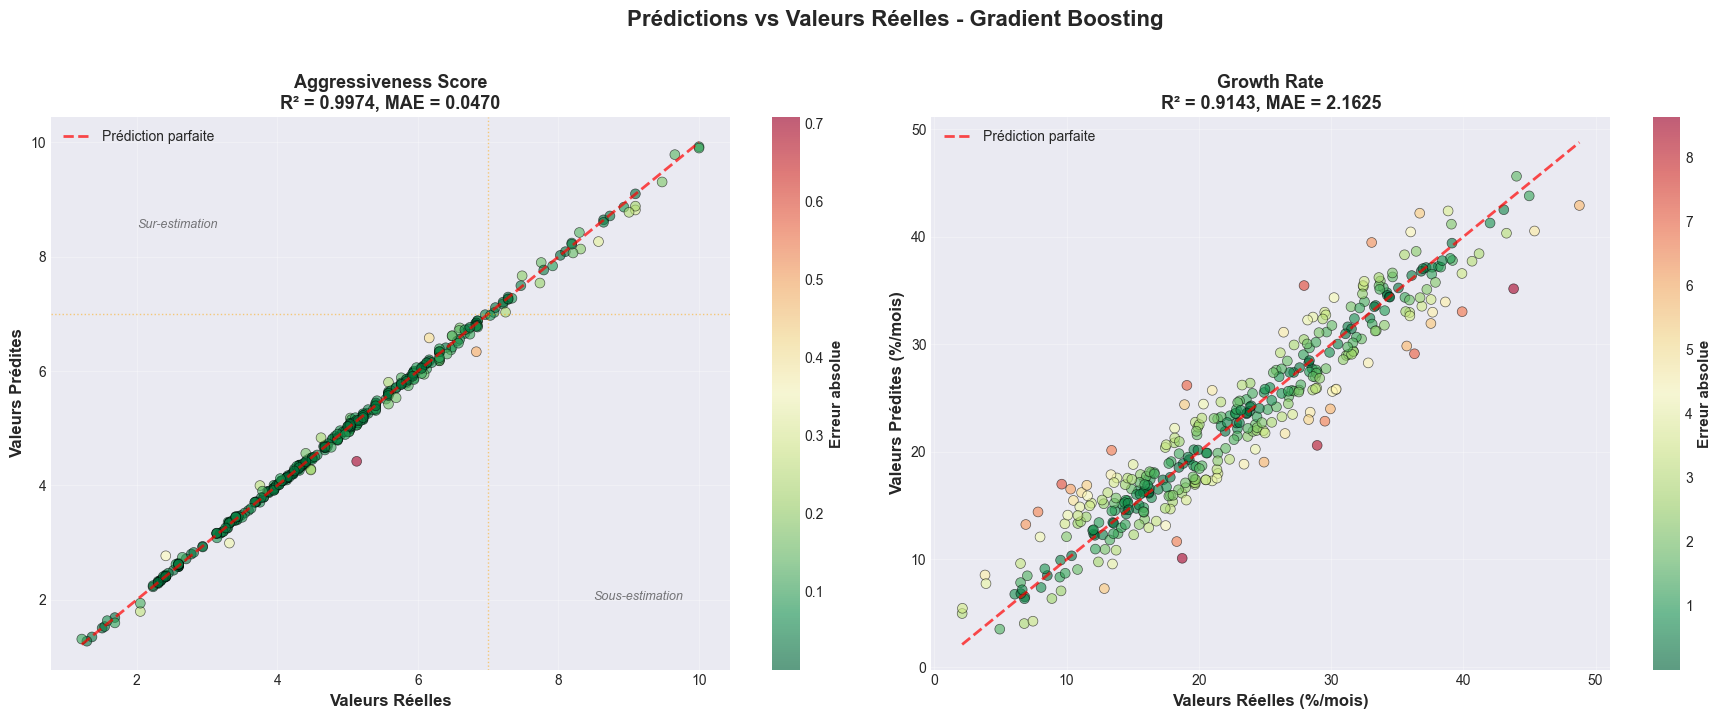


✅ Visualisation 1 générée : Prédictions vs Réel


In [25]:
print("\n" + "="*80)
print("📊 VISUALISATION : PRÉDICTIONS VS RÉEL")
print("="*80)

# ════════════════════════════════════════════════════════════════════════
# Créer figure avec 2 subplots
# ════════════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle(f'Prédictions vs Valeurs Réelles - {best_model_name}', 
             fontsize=16, fontweight='bold', y=1.02)

# ════════════════════════════════════════════════════════════════════════
# SUBPLOT 1 : Aggressiveness Score
# ════════════════════════════════════════════════════════════════════════

ax1 = axes[0]

# Scatter plot
scatter1 = ax1.scatter(
    y_test.iloc[:, 0],
    y_test_pred_final[:, 0],
    alpha=0.6,
    s=50,
    c=np.abs(y_test.iloc[:, 0] - y_test_pred_final[:, 0]),
    cmap='RdYlGn_r',
    edgecolors='black',
    linewidth=0.5
)

# Ligne diagonale parfaite
min_val = min(y_test.iloc[:, 0]. min(), y_test_pred_final[:, 0].min())
max_val = max(y_test.iloc[:, 0].max(), y_test_pred_final[:, 0].max())
ax1.plot([min_val, max_val], [min_val, max_val], 
         'r--', linewidth=2, label='Prédiction parfaite', alpha=0.7)

# Colorbar
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Erreur absolue', fontsize=11, fontweight='bold')

# Labels et titre
ax1.set_xlabel('Valeurs Réelles', fontsize=12, fontweight='bold')
ax1.set_ylabel('Valeurs Prédites', fontsize=12, fontweight='bold')
ax1.set_title(f'Aggressiveness Score\nR² = {final_metrics["aggressiveness"]["r2_test"]:.4f}, MAE = {final_metrics["aggressiveness"]["mae_test"]:.4f}',
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Annoter zones
ax1.axhline(7, color='orange', linestyle=':', alpha=0.5, linewidth=1)
ax1.axvline(7, color='orange', linestyle=':', alpha=0.5, linewidth=1)
ax1.text(8.5, 2, 'Sous-estimation', fontsize=9, alpha=0.6, style='italic')
ax1.text(2, 8.5, 'Sur-estimation', fontsize=9, alpha=0.6, style='italic')

# ════════════════════════════════════════════════════════════════════════
# SUBPLOT 2 : Growth Rate
# ════════════════════════════════════════════════════════════════════════

ax2 = axes[1]

# Scatter plot
scatter2 = ax2.scatter(
    y_test.iloc[:, 1],
    y_test_pred_final[:, 1],
    alpha=0.6,
    s=50,
    c=np.abs(y_test.iloc[:, 1] - y_test_pred_final[:, 1]),
    cmap='RdYlGn_r',
    edgecolors='black',
    linewidth=0.5
)

# Ligne diagonale parfaite
min_val = min(y_test.iloc[:, 1].min(), y_test_pred_final[:, 1].min())
max_val = max(y_test.iloc[:, 1].max(), y_test_pred_final[:, 1]. max())
ax2.plot([min_val, max_val], [min_val, max_val], 
         'r--', linewidth=2, label='Prédiction parfaite', alpha=0.7)

# Colorbar
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Erreur absolue', fontsize=11, fontweight='bold')

# Labels et titre
ax2.set_xlabel('Valeurs Réelles (%/mois)', fontsize=12, fontweight='bold')
ax2. set_ylabel('Valeurs Prédites (%/mois)', fontsize=12, fontweight='bold')
ax2.set_title(f'Growth Rate\nR² = {final_metrics["growth_rate"]["r2_test"]:.4f}, MAE = {final_metrics["growth_rate"]["mae_test"]:.4f}',
              fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualisation 1 générée : Prédictions vs Réel")